In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

In [2]:
def getRoundedThresholdv1(a, round_step):
    return np.round(a / round_step) * round_step

def produce_plots(data,lb, x_axis='iteration', q1=0.25,q2=0.75, f_ylim=(0, 0.75), c_ylim = (-0.01, 0.01)):# save=False, dataset_name=None):
    q1 = q1
    q2 = q2
    q3 = 0.5
    

    means = data.groupby(x_axis).mean()
    q_lower = data.groupby(by=x_axis).quantile(q=q1,interpolation='lower')
    q_mid = data.groupby(by=x_axis).quantile(q=q3,interpolation='linear')
    q_higher = data.groupby(by=x_axis).quantile(q=q2,interpolation='higher')
    
    f = plt.figure()
    
    ax1 = f.add_subplot()

    ax1.fill_between(x=means.index, y1=q_lower['Loss'], y2=q_higher['Loss'],alpha=0.4)
    ax1.plot(q_lower['Loss'], label=f'Q{int(q1*100)}',c='black', lw=0.6)
    ax1.plot(q_higher['Loss'], label=f'Q{int(q2*100)}',c='black', lw=0.6)
    ax1.plot(q_mid['Loss'], label=f'Median',c='darkorange', lw=0.6)
    ax1.plot(means['Loss'], label='Mean')
    xt = ax1.get_xticks()
    xt_ind = xt[1:-1] - 1
    xt_ind[0] = 0
    # ax1.set_xticks(means['SampleSize'].cumsum()[xt_ind])
    # ax1.set_xticklabels(labels=np.round(means['SampleSize'].cumsum()[xt_ind], 0), rotation=45)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # if save:
        # f.savefig('C:/Users/andre/docs/plots/sslalm/income_race/loss
    
    f_ = plt.figure()
    ax2 = f_.add_subplot()

    ax2.fill_between(x=means.index, y1=q_lower['C1'], y2=q_higher['C1'],alpha=0.4)
    ax2.plot(q_lower['C1'], ls = '-', label=f'Q{int(q1*100)}',c='black', lw=0.6)
    ax2.plot(q_higher['C1'], ls = '-', label=f'Q{int(q2*100)}',c='black', lw=0.6)
    ax2.plot(q_mid['C1'], label=f'Median',c='darkorange')
    ax2.plot(means['C1'], label='Mean')

    ax2.set_xlabel('Iteration')
    # ax2.set_ylim(bottom=-0.02, top=0.02)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(data['iteration']), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(data['iteration']), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    ax2.legend()
    return f, f_
    
def plot_separate_trajectories(data, lb, x_axis, alpha=0.5, lw=1, legend=True):
    f = plt.figure()
    ax1 = f.add_subplot()
    f = plt.figure()
    ax2 = f.add_subplot()
    for EXP_NUM in data['trial'].unique():
        traj = data[data['trial'] == EXP_NUM]
        if x_axis == 'time':
            x = traj['time']
        elif x_axis == 'iteration':
            x = traj['iteration']
        if isinstance(alpha, list):
            _a = alpha[EXP_NUM]
        else:
            _a = alpha
        if _a == 0:
            continue
        ax1.plot(x, traj['Loss'], label='Loss - trial {EXP_NUM}', alpha=_a, lw=lw)
        ax2.plot(x, traj['C1'], label=f'C1 - trial {EXP_NUM}', alpha=_a, lw=lw)
    
    ax1.set_xlabel('iteration' if x_axis == 'iteration' else 'time, s')
    # ax1.set_ybound(0, 1)
    ax2.set_xlabel('iteration' if x_axis == 'iteration' else 'time, s')
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(data[x_axis]), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(data[x_axis]), ls='--', colors='black', alpha=0.5)
    # ax2.set_ybound(-0.02, 0.04)
    ax2.set_ylabel('$L_w-L_b$')
    if legend:
        ax2.legend()
    # f.show()
    
def produce_plots_time(data, lb, round_step=0.5, fill='bfill', fill_limit=None, q1=0.25,q2=0.75, f_ylim=(0.4, 0.75), c_ylim = (-0.06, 0.07)):
    q3 = 0.5
    
    data['time_r'] = getRoundedThresholdv1(data['time'], round_step)
    
    time_step_idx = pd.Index(np.arange(0, max(data['time_r']), step=round_step))
    
    trials = []
    
    for EXP_NUM in data['trial'].unique():
        trial_stats = data[data['trial'] == EXP_NUM]
        trial_stats.index = trial_stats['time_r']
        trial_stats= trial_stats.reindex(time_step_idx, copy=True)
        trial_stats['time_r'] = trial_stats.index
        if fill == 'bfill':
            trial_stats.bfill(inplace=True, limit=fill_limit)
        elif fill == 'ffill':
            trial_stats.ffill(inplace=True, limit=fill_limit)
        else:
            trial_stats.interpolate(fill, inplace=True, limit_direction='forward')
        trials.append(trial_stats)
        
    trials = pd.concat(trials, ignore_index=True)
    trials_gr = trials.groupby('time_r')
    
    # f, axs = plt.subplots(1,5)
    # for EXP_NUM in data['trial'].unique():
    #     axs[EXP_NUM].set_title(EXP_NUM)
    #     tr = trials[trials['trial'] == EXP_NUM]
    #     axs[EXP_NUM].plot(tr['time_r'], tr['Loss'])

    means = trials_gr.mean()
    q_lower = trials_gr.quantile(q=q1,interpolation='lower')
    q_mid = trials_gr.quantile(q=q3,interpolation='linear')
    q_higher = trials_gr.quantile(q=q2,interpolation='higher')
    
    f = plt.figure()
    
    ax1 = f.add_subplot()

    ax1.fill_between(x=means.index, y1=q_lower['Loss'], y2=q_higher['Loss'],alpha=0.4)
    ax1.plot(q_lower['Loss'], label=f'Q{int(q1*100)}',c='black',lw=0.6)
    ax1.plot(q_higher['Loss'], label=f'Q{int(q2*100)}',c='black',lw=0.6)
    ax1.plot(q_mid['Loss'], label='Median',c='darkorange')
    ax1.plot(means['Loss'], label='Mean')
    ax1.set_ylim(bottom=f_ylim[0], top=f_ylim[1])
    
    xt = ax1.get_xticks()
    xt_ind = xt[1:-1] - 1
    xt_ind[0] = 0
    # ax1.set_xticks(means['SampleSize'].cumsum()[xt_ind])
    # ax1.set_xticklabels(labels=np.round(means['SampleSize'].cumsum()[xt_ind], 0), rotation=45)

    ax1.set_xlabel('time, s')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    f_ = plt.figure()
    ax2 = f_.add_subplot()

    ax2.fill_between(x=means.index, y1=q_lower['C1'], y2=q_higher['C1'],alpha=0.4)
    ax2.plot(q_lower['C1'], ls = '-', label=f'Q{int(q1*100)}',c='black', lw=0.6)
    ax2.plot(q_higher['C1'], ls = '-', label=f'Q{int(q2*100)}',c='black', lw=0.6)
    ax2.plot(q_mid['C1'], label='Median',c='darkorange')
    ax2.plot(means['C1'], label='Mean')

    ax2.set_xlabel('time, s')
    # ax2.set_ylim(bottom=-0.02, top=0.02)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=max(means.index), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=max(means.index), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    ax2.legend()
    ax2.set_ylim(bottom=c_ylim[0], top=c_ylim[1])
    
    return f, f_

In [3]:
import re

def parse_parameter_string(s):
    s = s.lstrip('_')
    # Order variables by descending length to avoid substring matches
    variables = ['lambda', 'gamma', 'zeta', 'beta', 'rho', 'tau', 'ss', 'a']
    # Split into "ss" and numeric variables
    numeric_vars = [v for v in variables if v != 'ss']
    ss_var = 'ss'
    
    # Build regex pattern dynamically
    numeric_part = '|'.join(numeric_vars)
    lookahead = f'(?={numeric_part}|{ss_var}|$)'
    
    # Match "ss" first (string value) or numeric variables
    pattern = re.compile(
        rf'({ss_var})(.*?){lookahead}'  # "ss" with arbitrary value
        rf'|({"|".join(numeric_vars)})(\d+\.?\d*){lookahead}'  # numeric vars
    )
    
    result = {}
    for match in pattern.finditer(s):
        if match.group(1):  # "ss" case
            result[match.group(1)] = match.group(2)
        else:  # numeric case
            result[match.group(3)] = float(match.group(4))
    
    return result

**Read results:**

In [4]:
# TASK = 'employment'
TASK = 'income'
STATE = 'ok'

DATASET = TASK +'_'+ STATE
lb = 0.005
geomp = 0.4
sampling = 1
# alg = 'fairret'
# alg_post = '_bs128cfscorellsem0.5'
# alg_post = '_bs24cacclklm0.5'
# alg = 'sg'
# alg_post= '_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05tau1.0ssdimin'
# alg_post ='_classtest'
# alg = 'sslalm'
# alg_post = '_1'
# alg_post = '_mu0.0rho1.0tau0.01eta0.05beta1.0'
# alg_post = '_mu2.0rho1.0tau0.01eta0.05beta0.5'
alg = 'swsg'
# alg_post = '_ctol0.0001fsrconstfs0.5csrconstcs0.05'
alg_post = '_eqss'
# alg_post = '_ctol0.000fsrconstfs0.2csrdimincs1.0'
# alg_post = '_ctol0.0005fsrconstfs0.5csrconstcs0.05'
# alg = 'sgd'
# alg_post = '_bs8'
alg += alg_post
constraint = 'loss'

if alg.startswith('sg') and not alg.startswith('sgd'):
    filename = f'./utils/exp_results/{alg}_' + f'{DATASET}_{lb}_{geomp}.csv'
else:
    filename = f'./utils/exp_results/{alg}_' + f'{DATASET}_{lb}.csv'
    
# filename = f'./src/experiments/utils/exp_results/sslalm_employment_az_0.005_1_REPORT.csv'
    
stats = pd.read_csv(filename)
if alg_post.startswith('_mu0'):
    alg = 'sslalm_aug'

In [5]:
stats_train = stats[stats['is_train'] == 'train'].drop(['is_train'], axis=1).dropna()
stats_test = stats[stats['is_train'] == 'test'].drop(['is_train'], axis=1).dropna()
if 'time' in stats_test.columns:
    for trial_num in stats_test['trial'].unique():
        trial_start_time = stats_test.loc[stats_test['trial'] == trial_num].iloc[0]['time']
        stats_test.loc[stats_test['trial'] == trial_num, 'time'] -= trial_start_time

In [6]:
stats_train.SampleSize.mean()

np.float64(26.67592190889371)

**Plots w.r.t. time**

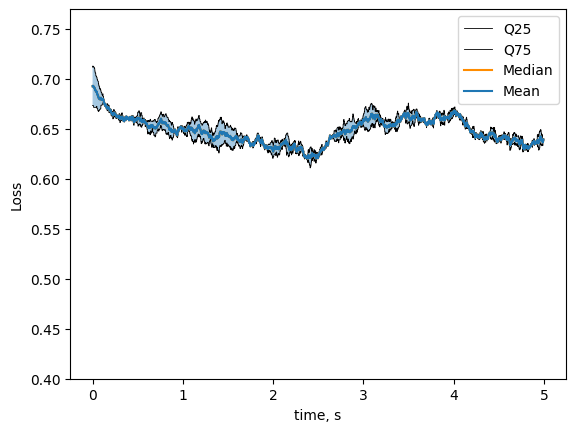

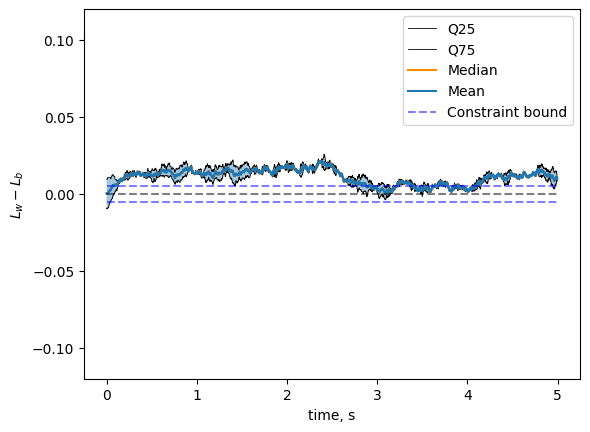

In [7]:
f1tr_time, f2tr_time = produce_plots_time(stats_train, lb, round_step=0.0005, f_ylim = (0.4, 0.77), c_ylim=(-0.12, 0.12))

In [8]:
f1tr_time.savefig(f'./plots/{alg.removesuffix(alg_post)}/{DATASET}/loss_train_time_{DATASET}')
f2tr_time.savefig(f'./plots/{alg.removesuffix(alg_post)}/{DATASET}/c_train_time_{DATASET}')
print(f'./plots/{alg.removesuffix(alg_post)}/{DATASET}')

./plots/swsg/income_ok


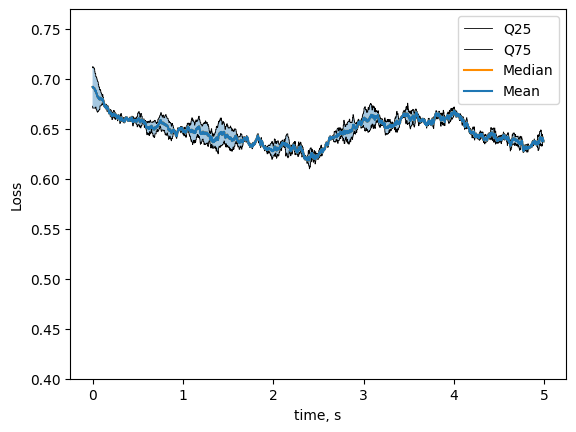

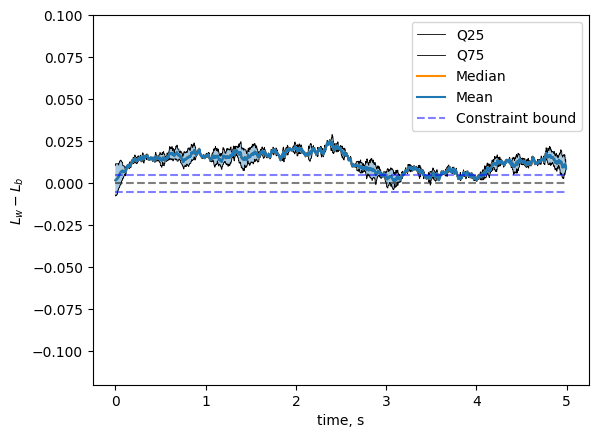

In [9]:
f1t_time, f2t_time = produce_plots_time(stats_test, lb, round_step=0.0005, f_ylim = (0.4, 0.77), c_ylim=(-0.12, 0.1))

In [10]:
f1t_time.savefig(f'./plots/{alg.removesuffix(alg_post)}/{DATASET}/loss_test_time_{DATASET}')
f2t_time.savefig(f'./plots/{alg.removesuffix(alg_post)}/{DATASET}/c_test_time_{DATASET}')

**Plots w.r.t. iteration**

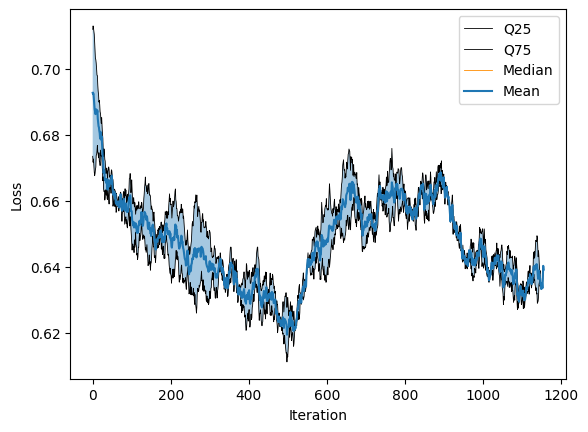

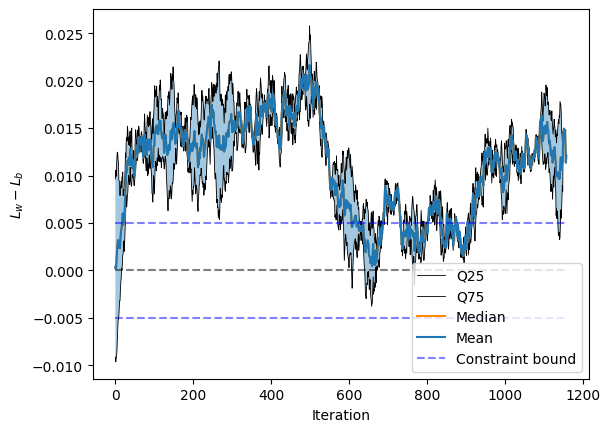

In [11]:
f1tr, f2tr = produce_plots(stats_train, lb, 'iteration')

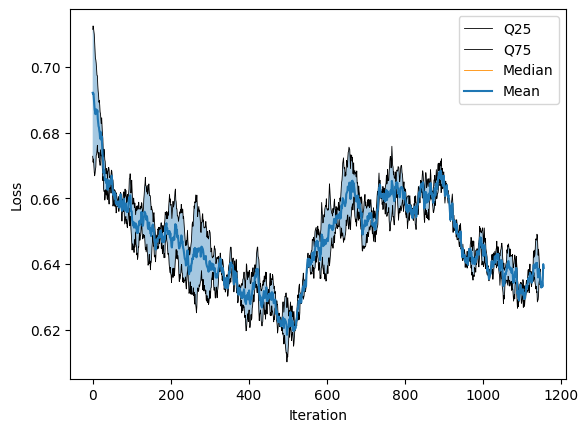

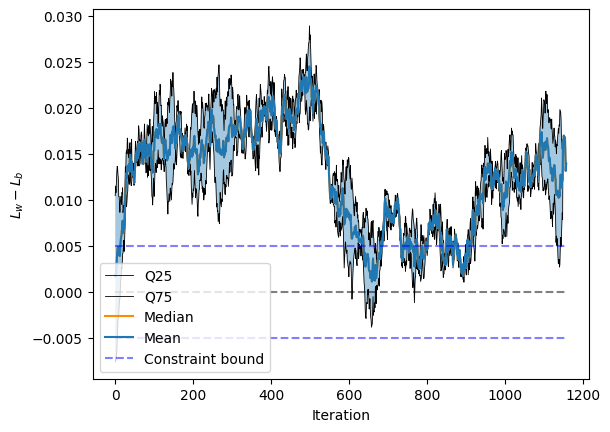

In [12]:
f1t, f2t = produce_plots(stats_test, lb, 'iteration')

**Trajectories:**

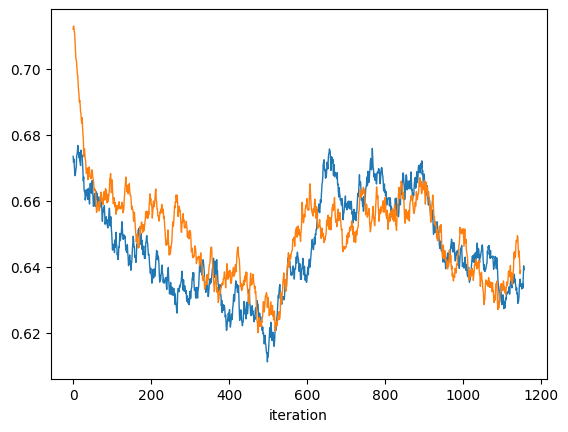

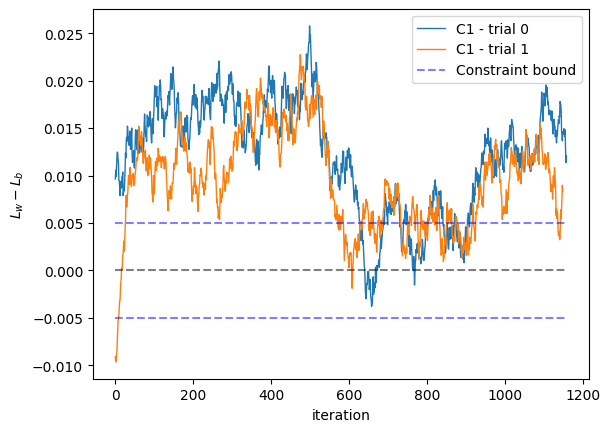

In [13]:
plot_separate_trajectories(stats_train, lb, 'iteration', alpha=1)